<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-3/blob/main/Distintos_Algoritmos_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carga de los datasets

In [1]:
!wget https://www.dropbox.com/s/0oibe9gy90sz08p/Prueba.zip?dl=0 -O prueba.zip

--2021-05-25 14:21:43--  https://www.dropbox.com/s/0oibe9gy90sz08p/Prueba.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0oibe9gy90sz08p/Prueba.zip [following]
--2021-05-25 14:21:43--  https://www.dropbox.com/s/raw/0oibe9gy90sz08p/Prueba.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2814057f42374d54efa6a83ac.dl.dropboxusercontent.com/cd/0/inline/BPKu-emApoFjtsseQTXx22SB6PUQssc87xqPdCqDIyaNESKQCXnHfFMYYBSV8bz5WUwZq37E0_31MfXW3uWXPvlKmLHwMQlFWM98TQUd49_ZBsshOaqkw5YhR6RU5JgyVs0Ko_bCRYqeuoa9NhOGYyyB/file# [following]
--2021-05-25 14:21:44--  https://uce2814057f42374d54efa6a83ac.dl.dropboxusercontent.com/cd/0/inline/BPKu-emApoFjtsseQTXx22SB6PUQssc87xqPdCqDIyaNESKQCXnHfFMYYBSV8bz5WUwZq37E0_31MfXW3uWXPvlK

In [2]:
!unzip prueba.zip

Archive:  prueba.zip
  inflating: Prueba/Prueba1.jpg      
  inflating: Prueba/Prueba2.jpg      


In [14]:
!pip install imutils
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [4]:
#@title
class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3(or_better=True)
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)
        # return the stitched image
        return result         
    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # check to see if we are using OpenCV 3.X
        if self.isv3:
            # detect and extract features from the image
            descriptor = cv2.ORB_create(nfeatures=1500)
            #.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)
        # otherwise, we are using OpenCV 2.4.X
        else:
            # detect keypoints in the image
            detector = cv2.FeatureDetector_create("ORB")
            kps = detector.detect(gray)
            # extract features from the image
            extractor = cv2.DescriptorExtractor_create("ORB")
            (kps, features) = extractor.compute(gray, kps)
        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
        # return a tuple of keypoints and features
        return (kps, features)   
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx)) 
        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
              reprojThresh)
            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)
        # otherwise, no homograpy could be computed
        return None 
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
      # initialize the output visualization image
      (hA, wA) = imageA.shape[:2]
      (hB, wB) = imageB.shape[:2]
      vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
      vis[0:hA, 0:wA] = imageA
      vis[0:hB, wA:] = imageB
      # loop over the matches
      for ((trainIdx, queryIdx), s) in zip(matches, status):
          # only process the match if the keypoint was successfully
          # matched
          if s == 1:
              # draw the match
              ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
              ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
              cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
      # return the visualization
      return vis


In [5]:
#@title
import matplotlib.pyplot as plt

def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

In [6]:
img1=cv2.imread("Prueba/Prueba1.jpg")
img2=cv2.imread("Prueba/Prueba2.jpg")

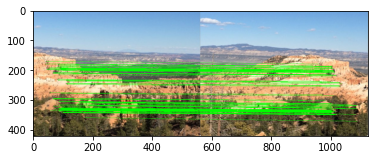

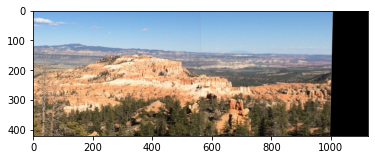

-1

In [9]:
# import the necessary packages
#from pyimagesearch.panorama import Stitcher
import argparse
import imutils
import cv2
# construct the argument parse and parse the arguments
##ap = argparse.ArgumentParser()
##ap.add_argument("-f", "--first", required=True,help="path to the first image")
##ap.add_argument("-s", "--second", required=True,help="path to the second image")
##args = vars(ap.parse_args())
# load the two images and resize them to have a width of 400 pixels
# (for faster processing)
##imageA = cv2.imread(args["first"])
##imageB = cv2.imread(args["second"])
##imageA = imutils.resize(imageA, width=400)
##imageB = imutils.resize(imageB, width=400)

# stitch the images together to create a panorama
stitcher = Stitcher()
(result, vis) = stitcher.stitch([img1,img2], showMatches=True)
# show the images
mostrarImagen(vis)
mostrarImagen(result)
cv2.waitKey(0)

In [11]:
def draw_matches(rotada1, keypoints1, rotada2, keypoints2, matches):
    r, c = rotada1.shape[:2]
    r1, c1 = rotada2.shape[:2]

    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([rotada1, rotada1, rotada1])
    output_img[:r1, c:c+c1, :] = np.dstack([rotada2, rotada2, rotada2])

    # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
    return output_img

In [12]:
def warpImages(img1, img2, H):

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
    translation_dist = [-x_min, -y_min]
  
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

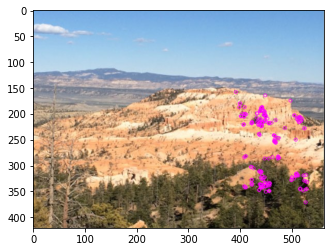

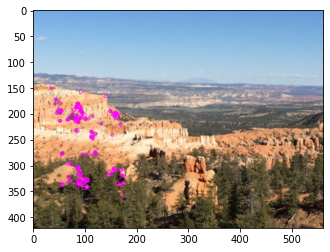

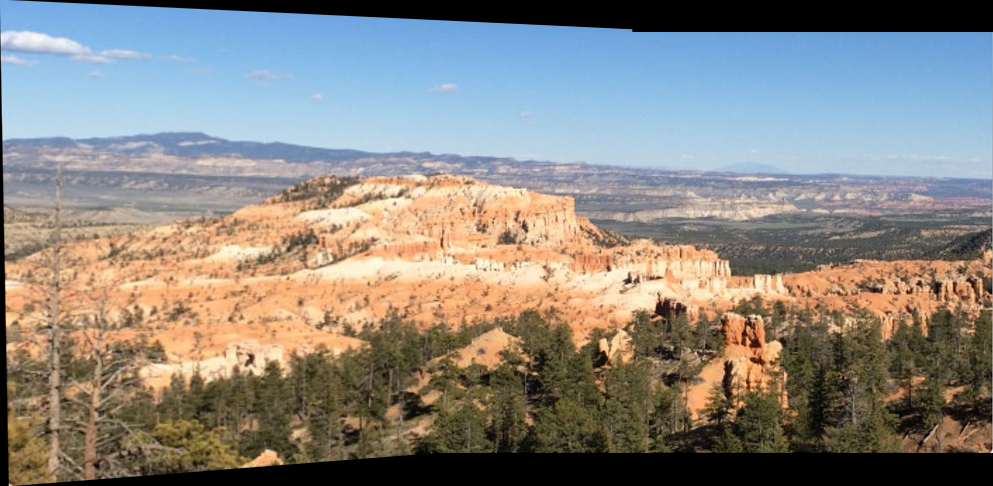

In [19]:
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  # Create our ORB detector and detect keypoints and descriptors
  orb = cv2.ORB_create(nfeatures=2000)

  # Find the key points and descriptors with ORB
  keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
  keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
  img1KeyPoints=cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255))
  img2KeyPoints=cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255))
  # Create a BFMatcher object.
  # It will find all of the matching keypoints on two images
  bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

  # Find matching points
  matches = bf.knnMatch(descriptors1, descriptors2, k=2)
  all_matches = []
  for m, n in matches:
      all_matches.append(m)

  img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
  # Finding the best matches
  good = []
  for m, n in matches:
      if m.distance < 0.6 * n.distance:
          good.append(m)
  mostrarImagen(cv2.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255)))
  mostrarImagen(cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255)))
  MIN_MATCH_COUNT = 10

  if len(good) > MIN_MATCH_COUNT:
      # Convert keypoints to an argument for findHomography
      src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
      dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

      # Establish a homography
      M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
      
      result = warpImages(img2, img1, M)

      cv2_imshow(result)